<a href="https://colab.research.google.com/github/KamaljeetSahoo/6thSense/blob/master/ASL_Classification_6thSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset

In [ ]:
from IPython.display import clear_output

In [ ]:
!gdown --id 1lfgFK4brUhTemW3mXJVZBYTECYEoF50_

Downloading...
From: https://drive.google.com/uc?id=1lfgFK4brUhTemW3mXJVZBYTECYEoF50_
To: /content/asl-alphabet.zip
1.10GB [00:14, 78.5MB/s]


In [ ]:
!unzip /content/asl-alphabet.zip
clear_output()

Libraries

In [ ]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time

Dataset and Analysis

In [ ]:
image_folder = '/content/asl_alphabet_train/asl_alphabet_train'
print(sorted(os.listdir(image_folder)))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Data Augmentation

In [ ]:
from albumentations.pytorch import ToTensor
import albumentations as A



seq = A.Compose(
    [   A.Resize(224,224),
        A.HorizontalFlip(p = 0.5),
     A.Transpose(p=0.5),
        A.OneOf([
            A.MotionBlur(p=.3),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        
        
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)
    
    
seq_test=A.Compose(
    [   A.Resize(224,224), 
       A.Normalize(
            mean=[0.5454, 0.4439, 0.3438],
            std=[0.2702, 0.2731, 0.2785]),ToTensor() ])

In [ ]:
import imageio
import glob
from torch.utils.data import Dataset

class Custom_dataset(Dataset):
    def __init__(self,root='/content/merged_data',img_type='png',mnist=False,transforms=None):
      org_lst=os.listdir(root)
      org_lst.sort()
      cnt=0
      self.map={}
      self.root=root
      self.transforms=transforms
      self.lst=[]
     
      if root[-1]=='n':
           
        if mnist!=True:
          
          self.lst=glob.glob(root+'/**/*.'+img_type)
          for i in org_lst:
            #i=i.split('Sample')[0]
            if i not in self.map: 
              self.map.update({i:cnt})
              cnt+=1 
        else:

          self.lst=glob.glob(root+'/**/*.'+img_type)
          lst1=[]
          for i in self.lst:
            #print(int(i.split('/')[-1].split['-'][0][-3:]))
            if int(i.split('/')[-1].split('-')[0][-3:])<11:
              lst1.append(i)
          self.lst=lst1    

          for i in org_lst:
            #i=i.split('Sample')[0]
            if i not in self.map: 
              if int(i[-3:])<11:
               self.map.update({i:cnt})
              cnt+=1
      elif root[-1]=='t':
       self.lst=glob.glob(root+'/**/*.'+img_type)
       for i in org_lst:
          if i not in self.map: 
            self.map.update({i:cnt})
            cnt+=1 
      
      


    def __getitem__(self, idx):
      path=self.lst[idx]

      #print(img_p)
      #label=self.map[path.split('/')[-1].split('-')[0]]
      label=self.map[path.split('/')[-2]]
      
      im=imageio.imread(path)
      im_tensor=im
      if self.transforms is not None:
         im_tensor=self.transforms(image=im)['image']
        
      return im_tensor, torch.tensor(label).long() 
      
    def __len__(self):
      #print(len(self.data))
      return len(self.lst)

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=42)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

Dont run only the below cell if transfomation is required

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(root = image_folder, transform =transform )
classes = dataset.classes
print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Run this instead

In [ ]:
dataset=Custom_dataset(root='/content/asl_alphabet_train/asl_alphabet_train',img_type='jpg',mnist=False,transforms=seq)

In [ ]:
datasets = train_val_dataset(dataset)

DataLoader

In [ ]:
batch = 512
dataloaders = {x:DataLoader(datasets[x],batch_size=batch, shuffle=True, num_workers=2, drop_last=True) for x in ['train','val']}

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

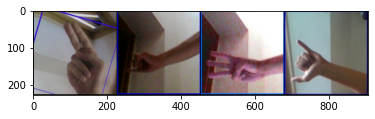

    H     I     W     Y


In [ ]:
# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch)))

Training Device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Model

In [ ]:
print(torchvision.__version__)

0.9.1+cu101


In [ ]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(in_features=1024, out_features=len(classes), bias=True)
model

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

Training Parameters

In [ ]:
PATH = '/content/epoch.pt'
model = model.to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
model = model.to(device)
model = model.train()
min_loss = 100
patience = 4
training_loss_store = []
validation_loss_store = []
step = 0
loss_train = []
loss_val = []

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epoch_list = []
loss_list = []
loss_list_val = []
no_impr_epoch = 0

Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print('training started.............................................')
start_time = time.time()
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_list.append(epoch)
    train_loss = 0
    for i, data in enumerate(dataloaders['train'], 0):
        step+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        train_loss += loss.item() * inputs.size(0)
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 30))
            loss_train = []
            running_loss = 0.0

    train_loss = train_loss / len(dataloaders['train'])
    loss_list.append(train_loss)      
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    print('################################evaluation###########################\n')
    with torch.no_grad():
        val_loss = 0
        model.eval()
        loss_val_x = 0
        
        for i, data in enumerate(dataloaders['val'], 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            loss_val_x += loss.item() * inputs.size(0)
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        loss_val_x = loss_val_x/len(dataloaders['val'])
        loss_list_val = loss_val.append(loss_val)
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            torch.save(model.state_dict(), 'epoch.pt')
            print(str(val_loss))
            
            print('performance improved with validation loss ' + str(val_loss))
            
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            
        if no_impr_epoch > patience:
            print('stop training')
            break
    
print('Finished Training................................................')
end_time = time.time()

training started.............................................
[1,    30] loss: 2.053
[1,    60] loss: 1.765
[1,    90] loss: 1.506
[1,   120] loss: 1.305
Finished training for epoch 0 time taken = 290.9146010875702
################################evaluation###########################

tensor(0.4200, device='cuda:0')
performance improved with validation loss tensor(0.4200, device='cuda:0')
[2,    30] loss: 0.205
[2,    60] loss: 0.101
[2,    90] loss: 0.093
[2,   120] loss: 0.083
Finished training for epoch 1 time taken = 639.9618618488312
################################evaluation###########################

tensor(0.0788, device='cuda:0')
performance improved with validation loss tensor(0.0788, device='cuda:0')
[3,    30] loss: 0.073
[3,    60] loss: 0.075
[3,    90] loss: 0.069
[3,   120] loss: 0.068
Finished training for epoch 2 time taken = 1012.6475644111633
################################evaluation###########################

tensor(0.0599, device='cuda:0')
performance improved 

In [ ]:
PATH = '/content/epoch.pt'
model = model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        #c = (predicted == labels).squeeze() 
        c = (predicted == labels)
        for i in range(batch):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     A : 99 %
Accuracy of     B : 99 %
Accuracy of     C : 99 %
Accuracy of     D : 98 %
Accuracy of     E : 99 %
Accuracy of     F : 99 %
Accuracy of     G : 98 %
Accuracy of     H : 99 %
Accuracy of     I : 96 %
Accuracy of     J : 99 %
Accuracy of     K : 99 %
Accuracy of     L : 99 %
Accuracy of     M : 99 %
Accuracy of     N : 97 %
Accuracy of     O : 99 %
Accuracy of     P : 99 %
Accuracy of     Q : 99 %
Accuracy of     R : 98 %
Accuracy of     S : 99 %
Accuracy of     T : 99 %
Accuracy of     U : 99 %
Accuracy of     V : 98 %
Accuracy of     W : 99 %
Accuracy of     X : 97 %
Accuracy of     Y : 99 %
Accuracy of     Z : 98 %
Accuracy of   del : 99 %
Accuracy of nothing : 99 %
Accuracy of space : 99 %
